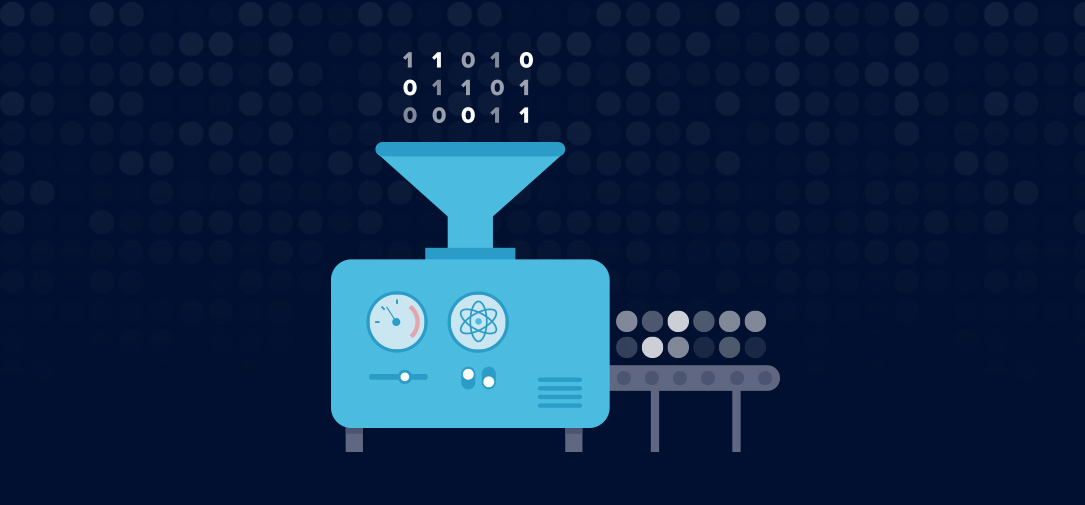

The purpose of this notbook is to perform the following tasks:
 
 1. [Load Packages and Data](#1)
 2. [Exploratory Data Analysis](#2)
 3. [Feature Engineering](#3)
 4. [Binning of variables and Imputation of missing values](#4)
 5. [Outlier Analysis and Feature Scaling](#5)
 6. [Modeling: xgboost](#6)
 
Main Findings:
 
 * The feature set can be divided into 3 data types: 
 
  1. Categorical Variables, 
  2. Numerical Variables and 
  3. Numeric Encoding Variables {C_X, D_X and V_X} 
  
  
 * 41% of the train_transaction is missing data.
 * 36% of the test_transaction is missing data.
 * 35% of train_identity is missing data.
 * 36% of test_identity is missing data.
 
At the end of the task the training and test datasets are imputed for missing values, scaled and fixed for outliers and features are binned to prevent overfitting. The results are saved as outputs of this notebook. The user can use the outputs of this notebook for model building.

### [Load Packages and Data](#1)<a id="1"></a> <br>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
#import xgboost as XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
train_transaction=pd.read_csv('../input/train_transaction.csv')
train_identity=pd.read_csv('../input/train_identity.csv')
test_transaction=pd.read_csv('../input/test_transaction.csv')
test_identity=pd.read_csv('../input/test_identity.csv')
sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')
print("Data is loaded")

### [Exploratory Data Analysis](#2)<a id="2"></a> <br>
 
 * Variables C_X and D_X have only integers as values and most of V_X as well. 
 * I strongly believe that C_X, D_X and V_X are numeric encoding. This is important to know when imputing the missing values, performing outlier analysis and modelling.
 * Varibles dist1, dist2 and TransactionAmt have a long tail distribution. Agian this is also important to realize when performing outlier analysis.
 * 41% of the train_transaction is missing.
 * 36% of the test_transaction is missing.
 * 35% of train_identity is missing data.
 * 36% of test_identity is missing data.

In [ ]:
print ("% of train_transaction data missing = ",(train_transaction[train_transaction.columns].isnull().sum().sum()/np.product(train_transaction.shape)) * 100)
print ("% of train_identity data missing = ",(train_identity[train_identity.columns].isnull().sum().sum()/np.product(train_identity.shape)) * 100)
print ("% of test_transaction data missing = ",(test_transaction[test_transaction.columns].isnull().sum().sum()/np.product(test_transaction.shape)) * 100)
print ("% of test_identity data missing = ",(test_identity[test_identity.columns].isnull().sum().sum()/np.product(test_identity.shape)) * 100)

In [ ]:
print(train_transaction.shape)
print(train_identity.shape)
print(test_transaction.shape)
print(test_identity.shape)

In [ ]:
train = train_transaction.merge(train_identity, left_on='TransactionID', right_on='TransactionID', how='left')
del train_identity, train_transaction
train = train.set_index('TransactionID', drop = 'True')

test = test_transaction.merge(test_identity, left_on='TransactionID', right_on='TransactionID', how='left')
del test_identity, test_transaction
test = test.set_index('TransactionID', drop = 'True')

In [ ]:
def datatype_conversion(df):

    card_cols = [c for c in df.columns if 'card' in c]
    for col in card_cols:
        df[col] = df[col].astype('object')

    addres_cols = [c for c in df.columns if 'addr' in c]
    for col in addres_cols:
            df[col] = df[col].astype('object')

    id_cols = [c for c in df.columns if 'id' in c]
    for col in id_cols:
            df[col] = df[col].astype('object')

    M_cols = [c for c in df.columns if 'M' in c]
    for col in M_cols:
            df[col] = df[col].astype('object')

    df['ProductCD'] = df['ProductCD'].astype('object')
    df['P_emaildomain'] = df['P_emaildomain'].astype('object')
    df['R_emaildomain'] = df['R_emaildomain'].astype('object')    
    df['DeviceType'] = df['DeviceType'].astype('object')
    df['DeviceInfo'] = df['DeviceInfo'].astype('object')
    
    return df

In [ ]:
train = datatype_conversion(train)
test = datatype_conversion(test)

In [ ]:
print(set(list(test.dtypes)))
print(set(list(train.dtypes)))

In [ ]:
print(test.shape)
print(train.shape)

In [ ]:
def variable_inspection(train, column):
    for col in column:
        print(train[col].value_counts(dropna = False))#.head(10))

In [ ]:
C_column = [c for c in train.columns if 'C' in c and 'ProductCD' not in c] 
D_column = [c for c in train.columns if 'D' in c and 'TransactionID' not in c
            and 'TransactionDT' not in c and 'DeviceType' not in c 
            and 'DeviceInfo' not in c and 'ProductCD' not in c] 
V_column = [c for c in train.columns if 'V' in c]
M_column = [c for c in train.columns if 'M' in c]
card_column = [c for c in train.columns if 'card' in c]
id_column = [c for c in train.columns if 'id' in c]

In [ ]:
variable_inspection(train, C_column)

In [ ]:
variable_inspection(train, D_column)

In [ ]:
variable_inspection(train, V_column)

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax = sns.distplot(train['dist1'], bins=10, hist=False, ax=ax1,label='train')
ax = sns.distplot(test['dist1'], bins=10, hist=False, ax=ax1, label='test')
ax1.set_title('dist1 Distribution', fontsize=14)

ax = sns.distplot(train['dist2'], bins=10, hist=False, ax=ax2, label='train')
ax = sns.distplot(test['dist2'], bins=10, hist=False, ax=ax2, label='test')
ax2.set_title('dist2 Distribution', fontsize=14)

ax = sns.distplot(train['TransactionAmt'], bins=2, hist=False, ax=ax3, label='train')
ax = sns.distplot(test['TransactionAmt'], bins=2, hist=False, ax=ax3, label='test')
ax3.set_title('TransactionAmt Distribution', fontsize=14)

### [Feature Engineering](#3)<a id="3"></a> <br>

* Day of the week and hour are engineerd from TransactionDT.
* The decimal part of the TransactionAmt is engineerd as an separate feature. 


In [ ]:
# New feature - decimal part of the transaction amount
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

# https://www.kaggle.com/fchmiel/day-and-time-powerful-predictive-feature
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

### [Binning of variables and Imputation of missing values](#4)<a id="4"></a> <br>
 
  * Before we go into the missing value imputation I have explicitly changed the dataype of some of the categorical features into type boolean beacuse some of the categorical features are loaded as numerical.
  * For numerical features dist1, dist2 and TransactionAmt the missing values are replaced by the mean of the column. The missing value of other features are replaced by -999
  * Variables C_X and D_X have only integers as values and most of V_X as well. There missing values are replaced by -999.
  * The rare values of all features other than dist1, dist2, TransactionAmt and TransactionDT are binned together. This is a very important step to perform to prevent overfitting when performing modelling.
  * To reduce the size of the datasets the kernel published by [MJ Bahamani](https://www.kaggle.com/mjbahmani/reducing-memory-size-for-ieee) is applied to the datasets. It is a very helpfull function.

In [ ]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
col = [c for c in train.columns if c  not in ['dist1', 'dist2', 'TransactionAmt','isFraud', 'TransactionDT']]

#x = train[col].copy()
for col in train[col].columns:
    print(col)
    value_counts = train[col].value_counts()
    labels = value_counts.index[value_counts < 2500]
    train[col][train[col].isin(labels)] = '-1'
    print(train[col].value_counts())

In [ ]:
%%time
train = reduce_mem_usage2(train)

In [ ]:
col = [c for c in test.columns if c  not in ['dist1', 'dist2', 'TransactionAmt','isFraud', 'TransactionDT']]

#x = train[col].copy()
for col in test[col].columns:
    print(col)
    value_counts = test[col].value_counts()
    labels = value_counts.index[value_counts < 2500]
    test[col][test[col].isin(labels)] = '-1'
    print(test[col].value_counts())

In [ ]:
%%time
test = reduce_mem_usage2(test)

In [ ]:
def missing_value_statistics(df):
    missing_values_count = df[df.columns].isnull().sum()
    print (missing_values_count.head())
    total_cells = np.product(df.shape)
    total_missing = missing_values_count.sum()
    
    print ("% of missing data = ",(total_missing/total_cells) * 100)

In [ ]:
#imputation of dist1, dist2 and TransactionAmt with the mean of the respective columns
subset_col_1 = [c for c in train.columns if c in ['dist1', 'dist2', 'TransactionAmt']]

imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
imputer_train = imputer.fit(train[subset_col_1])  
imputer_test = imputer.fit(train[subset_col_1]) 

train[subset_col_1] = imputer_train.transform(train[subset_col_1])
test[subset_col_1] = imputer_test.transform(test[subset_col_1])

missing_value_statistics(train[subset_col_1])
missing_value_statistics(test[subset_col_1])

#imputation of features other than dist1, dist2 and TransactionAmt with -999
subset_col_2 = [c for c in train.columns if c  not in ['dist1', 'dist2', 'TransactionAmt','isFraud', 'TransactionDT']]

for col in subset_col_2:
    train[col] = train[col].astype('object')
    
for col in subset_col_2:
    test[col] = test[col].astype('object')
    
train[subset_col_2] = train[subset_col_2].fillna(-999)
test[subset_col_2] = test[subset_col_2].fillna(-999)

missing_value_statistics(train[subset_col_2])
missing_value_statistics(test[subset_col_2])

In [ ]:
train_clean = train
test_clean = test
del train, test

### [Outlier Analysis and Feature Scaling](#5)<a id="5"></a> <br>
 
  * I have taken these two subjects under one section because I am using **RobustScaler()** to scale dist1, dist2 and TransactionAmt. **RobustScaler()** applies Inter Quartile Range(IQR) to scale the features when the argument **with_scaling=True**.
  * Outlier Analysis is contentious territory. I have opted for Inter Quartile Range (IQR) to detect outliers since it does not assume any distribution for the features.
  *  There are different ways to perform feature scaling. Here it has been opted for **RobustScaler()** because it is relatively more robust outliers. [Here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) you can find more information regarding this scaler. 
  *  It is applied only to dist1, dist2 and TransactionAmt features.

In [ ]:
train_clean['TransactionAmt'] = np.log(train_clean['TransactionAmt']+1)
train_clean['dist1'] = np.log(train_clean['dist1']+1)
train_clean['dist2'] = np.log(train_clean['dist2']+1)

test_clean['TransactionAmt'] = np.log(test_clean['TransactionAmt']+1)
test_clean['dist1'] = np.log(test_clean['dist1']+1)
test_clean['dist2'] = np.log(test_clean['dist2']+1)

In [ ]:
def Robust_Scaler(df):
        cols_1 = [c for c in df.columns if c in ['dist1','dist2','TransactionAmt']]
        cols_2 = [c for c in df.columns if c not in cols_1]

        # RobustScaler is less prone to outliers.
        rob_scaler = RobustScaler(with_scaling=True, with_centering=False)
        train_clean_rob = pd.DataFrame(data=rob_scaler.fit_transform(df[cols_1]), columns=['dist1','dist2','TransactionAmt'])

        # Set the index of the scaled dataset. It is the same as the original dataset
        s=df.index
        train_clean_rob = train_clean_rob.set_index([s])

        #Merge the scaled dataset with the categorical features and the ["isFraud", "TransactionDT"] columns to get back the cleaned 
        #dataset but with scaled numerical columns
        train_clean_rob = pd.merge(train_clean_rob, df[cols_2],left_index=True, right_index=True)

        #Just a check of the dimensions.
        print(df.shape)
        print(train_clean_rob.shape)
    
        return train_clean_rob

In [ ]:
train_clean_rob = Robust_Scaler(train_clean)
test_clean_rob = Robust_Scaler(test_clean)

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))
ax = sns.distplot(train_clean_rob['dist1'], bins=10, hist=False, ax=ax1, label='train')
ax = sns.distplot(test_clean_rob['dist1'], bins=10, hist=False, ax=ax1, label='test')
ax1.set_title('dist1 Distribution After Scaling', fontsize=14)

ax = sns.distplot(train_clean_rob['dist2'], bins=10, hist=False, ax=ax2, label='train')
ax = sns.distplot(test_clean_rob['dist2'], bins=10, hist=False, ax=ax2, label='test')
ax2.set_title('dist2 Distribution After Scaling', fontsize=14)

ax = sns.distplot(train_clean_rob['TransactionAmt'], bins=2, hist=False, ax=ax3, label='train')
ax = sns.distplot(test_clean_rob['TransactionAmt'], bins=2, hist=False, ax=ax3, label='test')
ax3.set_title('TransactionAmt Distribution After Scaling', fontsize=14)

In [ ]:
train_clean_rob.to_csv('train_clean_RobustScaler.csv',index=True)
test_clean_rob.to_csv('test_clean_RobustScaler.csv',index=True)

### [Modeling: Xgboost](#6)<a id="6"></a> <br>

* The parameters are not optimised.
* The xgboost model is based on [this](copied from https://www.kaggle.com/xhlulu/ieee-fraud-xgboost-with-gpu-fit-in-40s) great kernel. 
* I am using scale_pos_weight to account for the imbalance in the target variable

In [ ]:
# Label Encoding
for f in train_clean_rob.columns:
    #print(f)
    if train_clean_rob[f].dtype=='object' and test_clean_rob[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_clean_rob[f].values) + list(test_clean_rob[f].values))
        train_clean_rob[f] = lbl.transform(list(train_clean_rob[f].values))
        test_clean_rob[f] = lbl.transform(list(test_clean_rob[f].values))

In [ ]:
#del X_train, y_train, X_val, y_val, dtrain, dvalidation, y_val_preds, y_val_preds_2
#del X, y, cols, tscv

train_col = train_clean_rob.columns#.tolist()
test_col = test_clean_rob.columns#.tolist()

cols = [c for c in train_clean_rob if c not in ['isFraud', 'TransactionID', 'TransactionDT']]
y=np.array(train_clean_rob['isFraud'])
X=np.array(train_clean_rob[cols])

# %% [code]
tscv = TimeSeriesSplit(n_splits=2)
for train_index, val_index in tscv.split(train_clean_rob):
    print("TRAIN:", train_index, "TEST:", val_index)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

del train_clean_rob

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=cols)
dvalidation = xgb.DMatrix(X_val, feature_names=cols)

params =  {'bagging_fraction': 0.8993155305338455, 
               'colsample_bytree': 0.7463058454739352,
               'feature_fraction': 0.7989765808988153, 
               'gamma': 0.6665437467229817, 
               'learning_rate': 0.013887824598276186,
               'max_depth': 16, 
               'min_child_samples': 170, 
               'num_leaves': 220, 
               'reg_alpha': 0.39871702770778467, 
               'reg_lambda': 0.24309304355829786, 
               'subsample': 0.7,
               'objective': 'binary:logistic'}

num_rounds=1000

train_labels = dtrain.get_label()
ratio= float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
params['scale_pos_weight'] = ratio

# %% [code]
bst = xgb.train(params, dtrain, num_rounds)
y_val_preds = (bst.predict(dvalidation) > 0.5).astype('int')
y_val_preds_2 = bst.predict(dvalidation)

pd.crosstab(
    pd.Series(y_val, name='Actual'),
    pd.Series(y_val_preds, name='Predicted'),
    margins=True
)

# %% [code]
print('Accuracy: {0:.2f}'.format(accuracy_score(y_val, y_val_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_val, y_val_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_val, y_val_preds)))
print('AUC ROC: {0:.2f}'.format(roc_auc_score(y_val, y_val_preds_2)))

Get feature importance of each feature. Importance type can be defined as:

‘weight’: the number of times a feature is used to split the data across all trees.

‘gain’: the average gain across all splits the feature is used in.

‘cover’: the average coverage across all splits the feature is used in.

‘total_gain’: the total gain across all splits the feature is used in.

‘total_cover’: the total coverage across all splits the feature is used in.

In [ ]:
def feature_importance_2(measure):
    feature_importances = bst.get_score(importance_type=measure)
    
    keys = list(feature_importances.keys())
    values = list(feature_importances.values())
    
    data = pd.DataFrame(data=values, index=keys, columns=[measure]).sort_values(by = measure, ascending=False)
    
    data[measure+'_rank'] = data[measure].rank(method = 'first', ascending = False)
    
    data.index.name='features'
    
    data = pd.DataFrame(data[measure+'_rank'])
    
    return data
    

In [ ]:
df = pd.DataFrame(index = cols)
df.index.name='features'

measures = ['gain',  'total_gain', 'weight', 'cover', 'total_cover']
for measure in measures:
    data = feature_importance_2(measure)
    df = df.merge(data, left_on='features', right_on='features', how='left')

In [ ]:
del X_train, y_train, X_val, y_val, dtrain, dvalidation, y_val_preds, y_val_preds_2, X, y, tscv

In [ ]:
X_test = test.drop(['TransactionDT'], axis=1)
del test
dtest = X_test.as_matrix()
dtest = xgb.DMatrix(dtest, feature_names=cols)
sample_submission['isFraud'] = bst.predict(dtest)
sample_submission.to_csv('Xgboost.csv')
df.to_csv('feature_importance.csv')